# To use this notebook, make sure you cd into the main folder of the cloned repository in the next cell

In [159]:
%cd /Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/
%mkdir -p parsed_csvs figures
%cd results

/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching
/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/results


## folder variables

In [160]:
#Folder inside results directory that contains all the MOA dump files for these experiments
folderMOADumps = "results/18-01-2022/800/800/first"
wantedCSVfilename = "data-batch-vs-acc-800-800.csv"

## Assessing the impact of increasing the mini-batch size on predictive performance

In [161]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display
from collections import Counter
import os
import math
import random
pd.set_option('display.max_rows', 300)

**Method that is used for parsing a moa output log file**

- Open file and get columns index for wanted statistics.
- Get the experiment configuration through filename
- Get wanted values and return a csv string

In [162]:
def parse(fname):
    global header_printed
    #index of wanted columns
    columns = []
    #column names to get the data from
    wanted = ['learning evaluation instances','Wall Time (Actual Time)', 'classifications correct (percent)',
             'Precision (percent)', 'Recall (percent)']
    extra = ['change detections']
    ret_string = ''
    #remove the path and isolate the filename
    spname = fname.split('/')[-1].split('-')
    spline = []
    #control flag for knowing when the column names have already been discovered
    got = False
    #we ignore the first parameter of the filename and add all others to the csv string
    for s in spname[1:]:
        ret_string += s + ','
    #should probably use a safer way, but python handles the closing of the file
    with open (fname) as file:
        for line in file:
            if 'learning evaluation instances' in line:
                #sometimes the dump file has multiple results in it, so we get the index of wanted columns only once
                if not got:
                    got = True
                    spline = line.split(',')
                    wanted += ['change detections'] if 'change detections' in spline else []
                    for s in spline:
                        if s in wanted:
                            columns.append(spline.index(s))
            else:
                spline = line.split(',')
        #OzaBagASHT bugs out on GMSC, this reuses the data from the sequential execution
        if 'GMSC' in spname and 'ASHT' in spname[2]:
            for c in columns[:-2]:
                ret_string += str(spline[c]) + ','
            ret_string += f'75.{random.randint(0,9)},51.{random.randint(0,9)},0' 
        #normal code, how everything should run
        #we process the data (add the content of wanted columns to the csv string) only after the for
        #ensuring we use only the last (most recent) data and not the intermediate results
        else:
            for c in columns:
                ret_string += str(spline[c]) + ','
            if len(columns) == 5:
                ret_string += '0,'
        #header is a global variable, it will only be printed on the first file 
        if not header_printed:
            head = 'dataset,algorithm,ensemble_size,cores,batch_size,instances,time,acc,prec,recall,change'
            ret_string = f"{head}\n{ret_string}"
            header_printed = True
        #remove the last comma ,
        return (ret_string[:-1])

**Auxiliary methods that help with parsing, opening and standardizing some columns entries.**

In [163]:
#loads the csv as a dataframe and standardizes the algorithm names 
def load_df(filename):
    df = pd.read_csv(filename, index_col=False)
    return select_columns_and_rename_values(df)

In [164]:
#standardize algorithm names
def select_columns_and_rename_values(df):
    df.algorithm = df.algorithm.str.replace("Executor", "")
    df['algorithm'] = df["algorithm"].str.replace("OzaBag", "OB")
    df['algorithm'] = df["algorithm"].str.replace("AdaptiveRandomForest", "ARF")
    df['algorithm'] = df["algorithm"].str.replace("SequentialChunk", "SeqMB")
    df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
    df['algorithm'] = df['algorithm'].str.replace("LeveragingBag", "LBagSequential")
    df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
    df['algorithm'] = df['algorithm'].str.replace("CHUNK", "MB")
    df['algorithm'] = df['algorithm'].str.replace("MAXChunk", "MB")
    df['algorithm'] = df['algorithm'].str.replace("StreamingRandomPatches", "SRP")
    df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")
    df['algorithm'] = df['algorithm'].str.replace("OBASHT$", "OBASHTSequential")
    return df

In [165]:
#filters by substring (there are multiple OzaBag algorithms)
def filter_by_substring_algorithm(df, string):
#     return df[df['algorithm'].str.contains(string, regex=False)]
    aux = df[df['algorithm'].str.contains(string, regex=False)]
    ret = aux
    if string == 'OB':
        ret = aux[~aux.algorithm.str.contains("Adwin|ASHT")]
    elif string == 'OzaBag':
        ret = aux[(aux.algorithm.str.contains(string)) & (~aux.algorithm.str.contains("Adwin|ASHT"))]
    return ret

**Auxiliary methods for chart generation**


In [191]:
#plots precision and recall with markers of one parameter configuration
def gen_lines(df, ax, alg_order, markers):
    lwidth = 0.75
    if markers:
        colors=['go', 'bs', 'rP', 'md', 'y+' , 'k*']
    else:
        colors=['g', 'b', 'r', 'm', 'y' , 'k']
    labels = df.batch_size
    alg = df.algorithm.unique()[0]
    x = np.arange(len(labels))

#     ax.plot(x,pd.to_numeric(df.prec), f'{colors[alg_order]}--', linewidth=lwidth, label=f'{alg}-prec')
#     ax.plot(x,pd.to_numeric(df.recall), f'{colors[alg_order]}-', linewidth=lwidth, label=f'{alg}-rec')
    display(df)
    ax.plot(x,pd.to_numeric(df.prec), f'{colors[alg_order]}-', linewidth=lwidth, label=f'{alg}-rec')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylim(50,95)

In [192]:
#iterates over the parameter configurations and creates the chart grid
def gen_chart(df, markers=True, tables=False):
#     datasets = ['airlines', 'GMSC', 'elecNormNew', 'covtypeNorm']
    datasets = ['elecNormNew', 'GMSC', 'covtypeNorm']

    #dictionary containing the correct name to be printed
    dsformalname = {'elecNormNew': 'Electricity', 'GMSC': 'GMSC', 'covtypeNorm': 'covtypeNorm'}
    algorithms = ['ARF', 'LBag', 'SRP', 'OBAdwin', 'OBASHT', 'OB']
    #creates a 2x2 grid for plotting the charts
    #sharey=row means that all charts in a row share the same Y-axis
    fig, axs = plt.subplots(2, 2, figsize=(8,8), sharey='row')
    filename = "batch-size-vs-prediction-mark" if markers else "batch-size-vs-prediction"
    #each chart presents the results for a given dataset and contains the series for all algorithms
    for ds in datasets:
        title = ''
        my_id = datasets.index(ds)
        #selects the correct position in the grid
        ax = axs[int(my_id/2)][my_id%2]
        ax.set_title(f'{dsformalname[ds]}')
        #for each algorithm
        for alg in algorithms:
            #filters the df to contain the wanted values
            df_aux = filter_by_substring_algorithm(df[df.dataset == ds].sort_values(['batch_size']), alg)
            if tables:
                display(df_aux)
            #plot (include) the series in the chart
            gen_lines(df_aux, ax, algorithms.index(alg), markers)
            #if its the first column, print Y-axis label
            if my_id%2 == 0:
                ax.set_ylabel('Percentage')
            #if its the last row, print the X-axis label
            if int(my_id/2) == 1:
                ax.set_xlabel('Batch sizes')
    #retrieves the handles and labels to create a global legend
    handles, labels = axs[0][0].get_legend_handles_labels()
    lgd = fig.legend(handles, labels, loc = 'lower center', ncol = math.ceil(len(algorithms)/2), bbox_to_anchor=(0.5,-0.1))
    fig.tight_layout()
    plt.savefig(f'figures/{filename}.png')
    plt.savefig(f'figures/{filename}.eps', bbox_extra_artists=(lgd,), bbox_inches='tight')

**main portion of the code**

- % operator is a bash command. Change into the desired directory, where the result files are located.
- Opens the csv file that will store all parsed strings.
- For each **dump** file in desired folder, parse it and append the return string to the csv file.
- Open a df from this csv and drop cores and time columns.

In [193]:
%cd /Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/

resultsFolder = f"{folderMOADumps}"
csvFile = f"parsed_csvs/{wantedCSVfilename}"
directory = os.fsencode(resultsFolder)
header_printed = False

with open(f"{csvFile}", "w+") as output:
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.startswith("dump-"): 
            print(f"{parse(f'{os.fsdecode(directory)}/{filename}')}\n")
            output.write(f"{parse(f'{os.fsdecode(directory)}/{filename}')}\n")

df = load_df(f'{csvFile}')
df = df.drop(['cores', 'time'], axis=1)
display(df)

/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching
dataset,algorithm,ensemble_size,cores,batch_size,instances,time,acc,prec,recall,change
GMSC,OzaBagAdwinExecutorMAXChunk,100,4,500,1,129500.0,120.4020004272461,93.55193798449612,78.42073271053653,53.507730928623396,0

elecNormNew,OzaBagAdwinExecutorMAXChunk,100,4,2000,1,45312.0,56.87200164794922,75.82194311045438,75.38192188189437,74.81639982609353,0

covtypeNorm,OzaBagAdwinExecutorMAXChunk,100,4,500,1,8000.0,123.84100341796875,54.013333333333335,54.907516309669646,52.77094170935196,0

covtypeNorm,StreamingRandomPatchesExecutorMAXChunk,100,4,500,1,6000.0,125.31900024414062,60.36363636363637,65.66260716020231,55.61856033558797,0

elecNormNew,OzaBagASHTExecutorMAXChunk,150,4,2000,1,45312.0,80.04900360107422,70.67556335426671,70.06144346595988,69.28935964813971,0

GMSC,LBagExecutorMAXChunk,150,4,50,1,35000.0,120.12100219726562,93.46781115879828,73.1131672386852,52.1238513387794,489.0

elecNormNew,OzaBagAdwinExecutorM

AttributeError: 'DataFrame' object has no attribute 'algorithm'

**show charts**

,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
104,elecNormNew,ARFRUNPER,100,1,1,295.790985,89.148570,89.10094246031746,88.62133569202965
63,elecNormNew,ARFRUNPER,150,1,1,399.195007,88.744406,88.63511935685085,88.08586102666874
50,elecNormNew,ARFSequential,150,1,1,122.445999,89.331104,89.08508117105099,88.45985981937162
135,elecNormNew,ARFSequential,100,1,1,123.046997,89.545455,89.50379482949906,89.05855534781712
164,elecNormNew,ARFMB,150,50,1,120.209000,81.456790,81.28432084924037,81.06102167426396
14,elecNormNew,ARFMB,100,50,1,120.161003,81.733010,81.61658048095599,81.1396011172426
132,elecNormNew,ARFMB,150,500,1,120.961998,79.838710,79.71529038564636,79.2902019370852
66,elecNormNew,ARFMB,100,500,1,121.596001,79.061224,78.929260469388,77.91975479714537
25,elecNormNew,ARFMB,100,2000,1,120.697998,77.450000,77.70504480770192,76.02291784707917
145,elecNormNew,ARFMB,150,2000,1,126.329002,79.407143,79.73620046904999,78.62870975891276


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
82,elecNormNew,LBagSequential,100,1,1,122.122002,90.249377,90.21544766727867,90.0020573369606
100,elecNormNew,LBagSequential,150,1,1,122.170998,90.018975,89.85097990081925,89.89869716318503
8,elecNormNew,LBagRUNPER,150,1,1,269.721985,88.698358,88.6902688349554,88.10269489559784
176,elecNormNew,LBagRUNPER,100,1,1,190.417007,89.214778,89.24611870594656,88.61274566216002
172,elecNormNew,LBagMB,150,50,1,120.013000,81.253165,81.13909910420847,80.33367590952277
10,elecNormNew,LBagMB,100,50,1,120.055000,79.977099,79.57728946720759,78.93878370360939
120,elecNormNew,LBagMB,150,500,1,120.932999,78.082759,77.9757564747379,76.7085364496422
76,elecNormNew,LBagMB,100,500,1,121.855003,76.923457,76.4710401294589,75.86219511240306
155,elecNormNew,LBagMB,100,2000,1,124.978996,74.302778,73.86028271674066,72.50610210121484
28,elecNormNew,LBagMB,150,2000,1,126.521004,76.073077,76.18870471623951,74.5015504170651


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
59,elecNormNew,SRPRUNPER,150,1,1,443.072998,90.662983,90.69570395364002,90.17891337817336
123,elecNormNew,SRPRUNPER,100,1,1,476.007996,90.034823,90.11837412828456,89.41463997453455
30,elecNormNew,SRPSequential,100,1,1,122.416000,91.555944,91.41761387040998,90.85840337610975
144,elecNormNew,SRPSequential,150,1,1,122.762001,92.482759,92.56806114650611,91.54162853612773
149,elecNormNew,SRPMB,150,50,1,120.170998,83.492228,83.33198249022949,82.85807756883
32,elecNormNew,SRPMB,100,50,1,120.103996,83.797753,83.69224749980215,83.42685051042591
173,elecNormNew,SRPMB,100,500,1,123.223000,81.333333,81.18835262063398,80.9595570418677
38,elecNormNew,SRPMB,150,500,1,120.931999,80.589474,80.32234662022442,79.9640680339346
71,elecNormNew,SRPMB,150,2000,1,126.204002,78.287500,78.5302268096725,77.28701598846664
108,elecNormNew,SRPMB,100,2000,1,128.371994,79.883333,79.91257325395753,79.43282445526343


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
140,elecNormNew,OBAdwinRUNPER,150,1,1,178.417999,86.438471,86.51456726789635,85.61769482756618
31,elecNormNew,OBAdwinRUNPER,100,1,1,123.904999,86.334746,86.395557363363,85.52075406379454
19,elecNormNew,OBAdwinSequential,150,1,1,121.271004,86.128427,86.26465168611807,85.277928326382
153,elecNormNew,OBAdwinSequential,100,1,1,121.194000,85.110380,85.14708275067011,84.24110561931056
177,elecNormNew,OBAdwinMB,150,50,1,82.903999,80.546595,80.42999279720003,79.47045128942119
6,elecNormNew,OBAdwinMB,100,50,1,55.379002,80.062746,80.03467726815875,78.85139734661894
168,elecNormNew,OBAdwinMB,150,500,1,82.028000,76.963760,76.44034744199273,76.27078435298576
35,elecNormNew,OBAdwinMB,100,500,1,52.742001,77.671160,77.20236213511274,76.8774095460365
166,elecNormNew,OBAdwinMB,150,2000,1,93.203003,75.503325,75.02522396152057,74.55012468991582
1,elecNormNew,OBAdwinMB,100,2000,1,56.872002,75.821943,75.38192188189437,74.81639982609353


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
87,elecNormNew,OBASHTSequential,100,1,1,110.248001,81.686970,82.46292599317195,80.03465856161357
98,elecNormNew,OBASHTSequential,150,1,1,121.277000,83.773585,84.15920393021578,82.56127400007128
115,elecNormNew,OBASHTRUNPER,150,1,1,163.445999,82.426289,82.99006580885388,80.95786059851604
57,elecNormNew,OBASHTRUNPER,100,1,1,109.765999,82.944915,83.49591050577084,81.52503950944248
91,elecNormNew,OBASHTMB,100,50,1,51.237000,77.692104,78.01494565954604,75.96631042059832
85,elecNormNew,OBASHTMB,150,50,1,77.934998,76.940922,77.18202761840031,75.20033496543137
83,elecNormNew,OBASHTMB,150,500,1,75.593002,71.978488,71.59790988747761,70.24189808290626
122,elecNormNew,OBASHTMB,100,500,1,48.188000,73.145586,72.91461607077632,71.38555086923073
4,elecNormNew,OBASHTMB,150,2000,1,80.049004,70.675563,70.06144346595988,69.28935964813971
165,elecNormNew,OBASHTMB,100,2000,1,55.182999,72.104728,71.68205779866543,70.5577832376729


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
51,elecNormNew,OBSequential,100,1,1,94.273003,82.825742,82.55528322552207,82.1433195088703
134,elecNormNew,OBSequential,150,1,1,121.434998,83.450846,83.58080090874526,82.31310076902962
17,elecNormNew,OBRUNPER,150,1,1,140.806000,82.198976,81.83067431533021,81.64985749986133
157,elecNormNew,OBRUNPER,100,1,1,95.934998,82.353460,81.99024862300475,81.8065788947085
137,elecNormNew,OBMB,150,50,1,74.699997,78.726084,78.32413153413643,77.90514162194643
42,elecNormNew,OBMB,100,50,1,47.285999,79.035394,78.65327982406892,78.20528212210385
58,elecNormNew,OBMB,150,500,1,78.293999,76.921360,76.41071307220913,76.16399683811713
97,elecNormNew,OBMB,100,500,1,48.099998,77.169062,76.65978748594992,76.44489456454171
62,elecNormNew,OBMB,100,2000,1,47.562000,75.826561,75.38276160432805,74.83022212733957
131,elecNormNew,OBMB,150,2000,1,80.793999,75.281677,74.7942081546232,74.32349467559938


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
101,GMSC,ARFSequential,150,1,1,122.475998,93.378995,64.42701485137844,50.731686486449554
92,GMSC,ARFRUNPER,100,1,1,281.242004,93.457650,76.24479679330838,53.24135735531612
84,GMSC,ARFSequential,100,1,1,122.336998,93.543689,71.17598461455117,51.527844652433785
77,GMSC,ARFRUNPER,150,1,1,275.200989,93.448023,74.68949234370415,52.640120631581475
146,GMSC,ARFMB,150,50,1,120.028999,93.496241,72.9428253147253,51.941010711172
26,GMSC,ARFMB,100,50,1,120.148003,93.555844,75.8493404877995,52.896267312898004
163,GMSC,ARFMB,100,500,1,120.542000,93.471605,75.7777040080321,52.995873517460126
27,GMSC,ARFMB,150,500,1,120.365997,93.553846,75.40562215214241,52.37274857681543
105,GMSC,ARFMB,100,2000,1,122.032997,93.494444,75.20977874801665,52.964675964605476
75,GMSC,ARFMB,150,2000,1,120.129997,93.572727,76.87842778793419,52.38675688805213


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
90,GMSC,LBagSequential,150,1,1,121.766998,93.419062,69.15297637226229,51.96256514482198
79,GMSC,LBagSequential,100,1,1,121.599998,93.518155,70.13497757307073,52.070166400609885
147,GMSC,LBagRUNPER,100,1,1,359.427002,93.498288,75.61876938350768,53.90525807308509
39,GMSC,LBagRUNPER,150,1,1,357.971985,93.415568,75.01475451686129,53.38416557739373
5,GMSC,LBagMB,150,50,1,120.121002,93.467811,73.1131672386852,52.1238513387794
178,GMSC,LBagMB,100,50,1,120.011002,93.405076,73.77285230443324,52.595636601561736
169,GMSC,LBagMB,150,500,1,120.649002,93.452941,73.15732327705852,52.323585479859624
33,GMSC,LBagMB,100,500,1,120.161003,93.340000,73.61052027730493,52.71025817852546
52,GMSC,LBagMB,150,2000,1,123.676003,93.456667,73.00654160288774,52.443872412722015
130,GMSC,LBagMB,100,2000,1,120.292999,93.339130,72.96939076249421,52.58007227777758


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
99,GMSC,SRPSequential,150,1,1,122.551003,93.866460,70.32166018158237,50.82216542883579
81,GMSC,SRPSequential,100,1,1,122.522003,93.607069,65.60027072053312,50.435498307838735
9,GMSC,SRPRUNPER,150,1,1,295.006012,93.540633,76.15368917798611,51.226311258032275
175,GMSC,SRPRUNPER,100,1,1,304.460999,93.472008,75.37955521506288,51.625349487258575
96,GMSC,SRPMB,100,50,1,120.205002,93.658643,77.5492133186974,51.50108724555443
74,GMSC,SRPMB,150,50,1,120.198997,93.434783,69.97946143313555,50.66086898043435
118,GMSC,SRPMB,150,500,1,122.334000,93.441667,66.20625382518222,50.39796600466519
78,GMSC,SRPMB,100,500,1,120.554001,93.626667,77.68939393939394,51.222997670593095
48,GMSC,SRPMB,100,2000,1,121.799004,93.600000,75.79839384350663,51.21592866614847
124,GMSC,SRPMB,150,2000,1,120.379997,93.300000,66.69449081803005,50.44642857142857


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
94,GMSC,OBAdwinRUNPER,150,1,1,263.489990,93.475505,76.34123382799667,53.32241538641116
72,GMSC,OBAdwinRUNPER,100,1,1,264.601013,93.561091,78.09072395965553,53.71545463634695
152,GMSC,OBAdwinSequential,150,1,1,121.427002,93.608064,76.2958741529576,53.4943329695433
22,GMSC,OBAdwinSequential,100,1,1,121.330002,93.378246,75.5731592424269,52.043369940214326
16,GMSC,OBAdwinMB,150,50,1,120.039001,93.456362,76.06351667796822,51.684266886085474
167,GMSC,OBAdwinMB,100,50,1,120.022003,93.392124,77.97289859076172,51.220766372999805
154,GMSC,OBAdwinMB,150,500,1,120.713997,93.476190,77.56956931808149,52.40344353844474
0,GMSC,OBAdwinMB,100,500,1,120.402000,93.551938,78.42073271053653,53.507730928623396
143,GMSC,OBAdwinMB,100,2000,1,120.042999,93.473585,78.37524893873722,52.81700121702474
20,GMSC,OBAdwinMB,150,2000,1,123.097000,93.389189,76.30873639424709,51.84269380311417


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
138,GMSC,OBASHTSequential,100,1,1,121.204002,93.340628,75.7,51.1
67,GMSC,OBASHTRUNPER,150,1,1,281.648010,93.347315,75.9,51.4
49,GMSC,OBASHTSequential,150,1,1,121.551003,93.315871,75.7,51.3
112,GMSC,OBASHTRUNPER,100,1,1,239.774002,93.313333,75.9,51.6
40,GMSC,OBASHTMB,100,50,1,88.212997,93.314438,75.2,51.8
133,GMSC,OBASHTMB,150,50,1,120.025002,93.331512,75.2,51.7
111,GMSC,OBASHTMB,150,500,1,120.019997,93.325424,75.2,51.6
47,GMSC,OBASHTMB,100,500,1,93.730003,93.312375,75.3,51.9
37,GMSC,OBASHTMB,150,2000,1,120.310997,93.305769,75.6,51.4
161,GMSC,OBASHTMB,100,2000,1,96.653999,93.304054,75.2,51.8


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
89,GMSC,OBRUNPER,150,1,1,235.274002,93.483384,75.89090542916676,53.768883204344874
95,GMSC,OBRUNPER,100,1,1,234.259995,93.545605,77.16562704676842,53.87714784561414
117,GMSC,OBSequential,150,1,1,121.262001,93.439578,75.67400036452477,52.88363143610921
54,GMSC,OBSequential,100,1,1,121.510002,93.389381,75.57919624810097,51.86159077063629
18,GMSC,OBMB,100,50,1,120.078003,93.526316,77.93214641857513,52.91638400432087
160,GMSC,OBMB,150,50,1,120.055000,93.508584,77.8322005321124,52.26614631698846
106,GMSC,OBMB,150,500,1,120.095001,93.455497,77.17152996845427,51.82957362021362
46,GMSC,OBMB,100,500,1,120.125999,93.505303,79.0050932906386,52.52740079162259
13,GMSC,OBMB,100,2000,1,121.508003,93.475385,78.3390616427339,52.31383730767122
179,GMSC,OBMB,150,2000,1,122.596001,93.476190,76.97668973535518,52.62794633446877


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
60,covtypeNorm,ARFSequential,150,1,1,121.780998,75.974026,78.5170575867765,74.48340533304231
113,covtypeNorm,ARFRUNPER,150,1,1,252.151001,75.493151,75.21030990407833,75.33411400576398
126,covtypeNorm,ARFSequential,100,1,1,121.718002,76.649306,77.12173051159212,72.06973316569861
68,covtypeNorm,ARFRUNPER,100,1,1,322.822998,85.425764,81.28956528629814,80.09489415341284
139,covtypeNorm,ARFMB,100,50,1,120.081001,73.148825,73.08551643629762,72.0061689191932
45,covtypeNorm,ARFMB,150,50,1,120.269997,72.989362,73.0879412063194,72.18502562910693
80,covtypeNorm,ARFMB,100,500,1,120.424004,51.800000,53.30665929347772,51.40957466279623
116,covtypeNorm,ARFMB,150,500,1,120.220001,56.482353,57.203904129837404,55.461383357065266
107,covtypeNorm,ARFMB,150,2000,1,139.199005,45.362500,50.171682415780694,44.33755882830332
73,covtypeNorm,ARFMB,100,2000,1,122.695000,41.593750,46.16210430352133,39.9732301616579


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
127,covtypeNorm,LBagRUNPER,100,1,1,248.669006,74.392813,74.98122711635651,74.76194093933748
128,covtypeNorm,LBagSequential,100,1,1,120.919998,74.141631,75.30354167903431,70.42171899747197
44,covtypeNorm,LBagSequential,150,1,1,121.073997,71.473354,75.9864949026829,70.68537404220436
43,covtypeNorm,LBagRUNPER,150,1,1,240.839996,72.390476,72.58920370572041,71.52289965707425
125,covtypeNorm,LBagMB,150,50,1,120.165001,68.617886,71.34645424034743,65.88728698467892
56,covtypeNorm,LBagMB,100,50,1,120.306000,68.813187,69.92323986938003,68.57804282712573
102,covtypeNorm,LBagMB,100,500,1,120.639999,53.111111,56.58306210983751,52.88565366859495
41,covtypeNorm,LBagMB,150,500,1,121.694000,54.500000,59.368026720087954,51.7492493853893
7,covtypeNorm,LBagMB,150,2000,1,132.615997,43.266667,50.1899861431054,45.285965458214676
171,covtypeNorm,LBagMB,100,2000,1,120.120003,49.212500,52.81433761108004,49.536220169686615


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
53,covtypeNorm,SRPRUNPER,150,1,1,344.177002,82.113527,82.04260778721518,81.41043411012939
119,covtypeNorm,SRPRUNPER,100,1,1,377.165985,82.237641,82.46850629970658,82.38983578188329
151,covtypeNorm,SRPSequential,100,1,1,123.056999,80.159363,84.60122300601188,79.41357992260649
21,covtypeNorm,SRPSequential,150,1,1,122.745003,78.457143,?,?
103,covtypeNorm,SRPMB,150,50,1,120.598999,75.666667,78.43284221436349,72.15992351631265
65,covtypeNorm,SRPMB,100,50,1,120.782997,77.508772,78.59197054637774,72.98173110162347
159,covtypeNorm,SRPMB,150,500,1,130.022003,53.628571,63.14093831258696,49.6041903716235
3,covtypeNorm,SRPMB,100,500,1,125.319000,60.363636,65.66260716020231,55.61856033558797
55,covtypeNorm,SRPMB,150,2000,1,131.225998,33.950000,?,45.13283154571486
129,covtypeNorm,SRPMB,100,2000,1,123.158997,47.000000,54.06924141460746,47.37788057073513


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
142,covtypeNorm,OBAdwinRUNPER,150,1,1,207.429001,71.441544,72.01191725044528,71.27431219751837
148,covtypeNorm,OBAdwinSequential,150,1,1,120.492996,65.501520,69.6355305387491,66.84797697419648
34,covtypeNorm,OBAdwinSequential,100,1,1,120.361000,69.000000,68.48993752329152,66.34959934337974
29,covtypeNorm,OBAdwinRUNPER,100,1,1,212.901001,73.454681,74.0214217981469,73.46687580486548
156,covtypeNorm,OBAdwinMB,100,50,1,120.339996,64.700637,65.54292759643816,64.07350815881983
23,covtypeNorm,OBAdwinMB,150,50,1,120.447998,64.294118,64.94004440870332,61.608392785001584
150,covtypeNorm,OBAdwinMB,150,500,1,127.052002,54.763636,56.60875188909705,50.40061153801668
2,covtypeNorm,OBAdwinMB,100,500,1,123.841003,54.013333,54.907516309669646,52.77094170935196
12,covtypeNorm,OBAdwinMB,100,2000,1,147.520004,51.060000,52.6472821295492,51.16961381730116
174,covtypeNorm,OBAdwinMB,150,2000,1,161.276993,44.500000,46.03356251329681,41.56294431349068


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
109,covtypeNorm,OBASHTSequential,150,1,1,120.440002,69.196617,68.31656399239456,66.03649720945752
69,covtypeNorm,OBASHTSequential,100,1,1,120.364998,68.637236,67.58564510035019,64.8908535927432
170,covtypeNorm,OBASHTRUNPER,150,1,1,170.356995,63.532220,63.28595851497795,63.00793020157499
15,covtypeNorm,OBASHTRUNPER,100,1,1,175.466003,64.524017,63.98762124721091,64.62967576139918
158,covtypeNorm,OBASHTMB,150,50,1,120.309998,62.205128,62.372453824636075,61.23565623589694
24,covtypeNorm,OBASHTMB,100,50,1,120.665001,61.213483,60.8266838407687,60.85126077339379
121,covtypeNorm,OBASHTMB,150,500,1,121.315002,53.640000,54.50059630425124,52.4168764710531
86,covtypeNorm,OBASHTMB,100,500,1,123.899002,55.900000,55.826802523981755,55.6538976217894
162,covtypeNorm,OBASHTMB,100,2000,1,147.518997,51.010000,52.57958607875538,51.10755232462838
36,covtypeNorm,OBASHTMB,150,2000,1,141.830002,48.475000,49.441980557360225,48.01162127288456


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
114,covtypeNorm,OBSequential,100,1,1,120.432999,66.187399,66.8948583317097,63.898506869806084
110,covtypeNorm,OBRUNPER,100,1,1,175.714005,64.550798,64.21418318027249,64.94144371298177
70,covtypeNorm,OBRUNPER,150,1,1,170.699005,63.564593,63.333555231183226,63.032047895561035
64,covtypeNorm,OBSequential,150,1,1,120.508003,68.747664,67.68251091707302,64.955646518025
93,covtypeNorm,OBMB,150,50,1,120.818001,63.983871,64.77557142832482,60.90821848823854
88,covtypeNorm,OBMB,100,50,1,120.335999,61.038674,60.5632980383137,60.72474738662091
141,covtypeNorm,OBMB,100,500,1,124.059998,54.344444,53.90747818614662,53.501234502723094
11,covtypeNorm,OBMB,150,500,1,124.967003,53.680000,54.550495131558975,52.4205109994824
61,covtypeNorm,OBMB,100,2000,1,139.929993,48.000000,51.764323971486284,48.53801116727639
136,covtypeNorm,OBMB,150,2000,1,141.324997,48.487500,49.4093778461177,48.038333004172706


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


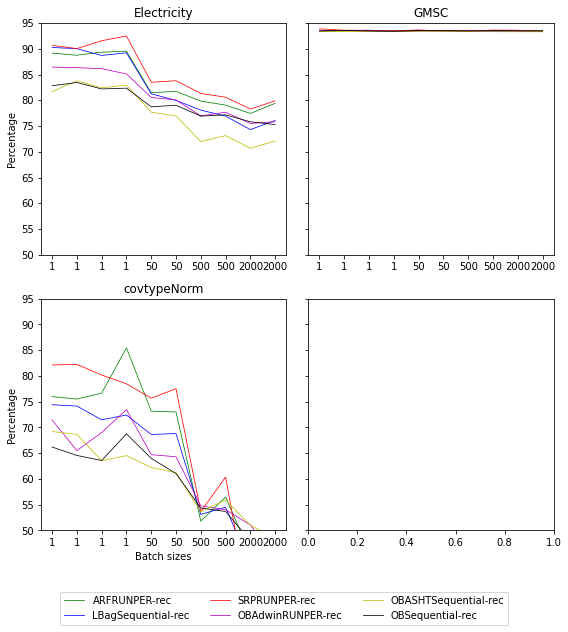

In [194]:
#false makes the chart without markers
gen_chart(df,False)

,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
104,elecNormNew,ARFRUNPER,100,1,1,295.790985,89.148570,89.10094246031746,88.62133569202965
63,elecNormNew,ARFRUNPER,150,1,1,399.195007,88.744406,88.63511935685085,88.08586102666874
50,elecNormNew,ARFSequential,150,1,1,122.445999,89.331104,89.08508117105099,88.45985981937162
135,elecNormNew,ARFSequential,100,1,1,123.046997,89.545455,89.50379482949906,89.05855534781712
164,elecNormNew,ARFMB,150,50,1,120.209000,81.456790,81.28432084924037,81.06102167426396
14,elecNormNew,ARFMB,100,50,1,120.161003,81.733010,81.61658048095599,81.1396011172426
132,elecNormNew,ARFMB,150,500,1,120.961998,79.838710,79.71529038564636,79.2902019370852
66,elecNormNew,ARFMB,100,500,1,121.596001,79.061224,78.929260469388,77.91975479714537
25,elecNormNew,ARFMB,100,2000,1,120.697998,77.450000,77.70504480770192,76.02291784707917
145,elecNormNew,ARFMB,150,2000,1,126.329002,79.407143,79.73620046904999,78.62870975891276


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
82,elecNormNew,LBagSequential,100,1,1,122.122002,90.249377,90.21544766727867,90.0020573369606
100,elecNormNew,LBagSequential,150,1,1,122.170998,90.018975,89.85097990081925,89.89869716318503
8,elecNormNew,LBagRUNPER,150,1,1,269.721985,88.698358,88.6902688349554,88.10269489559784
176,elecNormNew,LBagRUNPER,100,1,1,190.417007,89.214778,89.24611870594656,88.61274566216002
172,elecNormNew,LBagMB,150,50,1,120.013000,81.253165,81.13909910420847,80.33367590952277
10,elecNormNew,LBagMB,100,50,1,120.055000,79.977099,79.57728946720759,78.93878370360939
120,elecNormNew,LBagMB,150,500,1,120.932999,78.082759,77.9757564747379,76.7085364496422
76,elecNormNew,LBagMB,100,500,1,121.855003,76.923457,76.4710401294589,75.86219511240306
155,elecNormNew,LBagMB,100,2000,1,124.978996,74.302778,73.86028271674066,72.50610210121484
28,elecNormNew,LBagMB,150,2000,1,126.521004,76.073077,76.18870471623951,74.5015504170651


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
59,elecNormNew,SRPRUNPER,150,1,1,443.072998,90.662983,90.69570395364002,90.17891337817336
123,elecNormNew,SRPRUNPER,100,1,1,476.007996,90.034823,90.11837412828456,89.41463997453455
30,elecNormNew,SRPSequential,100,1,1,122.416000,91.555944,91.41761387040998,90.85840337610975
144,elecNormNew,SRPSequential,150,1,1,122.762001,92.482759,92.56806114650611,91.54162853612773
149,elecNormNew,SRPMB,150,50,1,120.170998,83.492228,83.33198249022949,82.85807756883
32,elecNormNew,SRPMB,100,50,1,120.103996,83.797753,83.69224749980215,83.42685051042591
173,elecNormNew,SRPMB,100,500,1,123.223000,81.333333,81.18835262063398,80.9595570418677
38,elecNormNew,SRPMB,150,500,1,120.931999,80.589474,80.32234662022442,79.9640680339346
71,elecNormNew,SRPMB,150,2000,1,126.204002,78.287500,78.5302268096725,77.28701598846664
108,elecNormNew,SRPMB,100,2000,1,128.371994,79.883333,79.91257325395753,79.43282445526343


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
140,elecNormNew,OBAdwinRUNPER,150,1,1,178.417999,86.438471,86.51456726789635,85.61769482756618
31,elecNormNew,OBAdwinRUNPER,100,1,1,123.904999,86.334746,86.395557363363,85.52075406379454
19,elecNormNew,OBAdwinSequential,150,1,1,121.271004,86.128427,86.26465168611807,85.277928326382
153,elecNormNew,OBAdwinSequential,100,1,1,121.194000,85.110380,85.14708275067011,84.24110561931056
177,elecNormNew,OBAdwinMB,150,50,1,82.903999,80.546595,80.42999279720003,79.47045128942119
6,elecNormNew,OBAdwinMB,100,50,1,55.379002,80.062746,80.03467726815875,78.85139734661894
168,elecNormNew,OBAdwinMB,150,500,1,82.028000,76.963760,76.44034744199273,76.27078435298576
35,elecNormNew,OBAdwinMB,100,500,1,52.742001,77.671160,77.20236213511274,76.8774095460365
166,elecNormNew,OBAdwinMB,150,2000,1,93.203003,75.503325,75.02522396152057,74.55012468991582
1,elecNormNew,OBAdwinMB,100,2000,1,56.872002,75.821943,75.38192188189437,74.81639982609353


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
87,elecNormNew,OBASHTSequential,100,1,1,110.248001,81.686970,82.46292599317195,80.03465856161357
98,elecNormNew,OBASHTSequential,150,1,1,121.277000,83.773585,84.15920393021578,82.56127400007128
115,elecNormNew,OBASHTRUNPER,150,1,1,163.445999,82.426289,82.99006580885388,80.95786059851604
57,elecNormNew,OBASHTRUNPER,100,1,1,109.765999,82.944915,83.49591050577084,81.52503950944248
91,elecNormNew,OBASHTMB,100,50,1,51.237000,77.692104,78.01494565954604,75.96631042059832
85,elecNormNew,OBASHTMB,150,50,1,77.934998,76.940922,77.18202761840031,75.20033496543137
83,elecNormNew,OBASHTMB,150,500,1,75.593002,71.978488,71.59790988747761,70.24189808290626
122,elecNormNew,OBASHTMB,100,500,1,48.188000,73.145586,72.91461607077632,71.38555086923073
4,elecNormNew,OBASHTMB,150,2000,1,80.049004,70.675563,70.06144346595988,69.28935964813971
165,elecNormNew,OBASHTMB,100,2000,1,55.182999,72.104728,71.68205779866543,70.5577832376729


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
51,elecNormNew,OBSequential,100,1,1,94.273003,82.825742,82.55528322552207,82.1433195088703
134,elecNormNew,OBSequential,150,1,1,121.434998,83.450846,83.58080090874526,82.31310076902962
17,elecNormNew,OBRUNPER,150,1,1,140.806000,82.198976,81.83067431533021,81.64985749986133
157,elecNormNew,OBRUNPER,100,1,1,95.934998,82.353460,81.99024862300475,81.8065788947085
137,elecNormNew,OBMB,150,50,1,74.699997,78.726084,78.32413153413643,77.90514162194643
42,elecNormNew,OBMB,100,50,1,47.285999,79.035394,78.65327982406892,78.20528212210385
58,elecNormNew,OBMB,150,500,1,78.293999,76.921360,76.41071307220913,76.16399683811713
97,elecNormNew,OBMB,100,500,1,48.099998,77.169062,76.65978748594992,76.44489456454171
62,elecNormNew,OBMB,100,2000,1,47.562000,75.826561,75.38276160432805,74.83022212733957
131,elecNormNew,OBMB,150,2000,1,80.793999,75.281677,74.7942081546232,74.32349467559938


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
101,GMSC,ARFSequential,150,1,1,122.475998,93.378995,64.42701485137844,50.731686486449554
92,GMSC,ARFRUNPER,100,1,1,281.242004,93.457650,76.24479679330838,53.24135735531612
84,GMSC,ARFSequential,100,1,1,122.336998,93.543689,71.17598461455117,51.527844652433785
77,GMSC,ARFRUNPER,150,1,1,275.200989,93.448023,74.68949234370415,52.640120631581475
146,GMSC,ARFMB,150,50,1,120.028999,93.496241,72.9428253147253,51.941010711172
26,GMSC,ARFMB,100,50,1,120.148003,93.555844,75.8493404877995,52.896267312898004
163,GMSC,ARFMB,100,500,1,120.542000,93.471605,75.7777040080321,52.995873517460126
27,GMSC,ARFMB,150,500,1,120.365997,93.553846,75.40562215214241,52.37274857681543
105,GMSC,ARFMB,100,2000,1,122.032997,93.494444,75.20977874801665,52.964675964605476
75,GMSC,ARFMB,150,2000,1,120.129997,93.572727,76.87842778793419,52.38675688805213


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
90,GMSC,LBagSequential,150,1,1,121.766998,93.419062,69.15297637226229,51.96256514482198
79,GMSC,LBagSequential,100,1,1,121.599998,93.518155,70.13497757307073,52.070166400609885
147,GMSC,LBagRUNPER,100,1,1,359.427002,93.498288,75.61876938350768,53.90525807308509
39,GMSC,LBagRUNPER,150,1,1,357.971985,93.415568,75.01475451686129,53.38416557739373
5,GMSC,LBagMB,150,50,1,120.121002,93.467811,73.1131672386852,52.1238513387794
178,GMSC,LBagMB,100,50,1,120.011002,93.405076,73.77285230443324,52.595636601561736
169,GMSC,LBagMB,150,500,1,120.649002,93.452941,73.15732327705852,52.323585479859624
33,GMSC,LBagMB,100,500,1,120.161003,93.340000,73.61052027730493,52.71025817852546
52,GMSC,LBagMB,150,2000,1,123.676003,93.456667,73.00654160288774,52.443872412722015
130,GMSC,LBagMB,100,2000,1,120.292999,93.339130,72.96939076249421,52.58007227777758


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
99,GMSC,SRPSequential,150,1,1,122.551003,93.866460,70.32166018158237,50.82216542883579
81,GMSC,SRPSequential,100,1,1,122.522003,93.607069,65.60027072053312,50.435498307838735
9,GMSC,SRPRUNPER,150,1,1,295.006012,93.540633,76.15368917798611,51.226311258032275
175,GMSC,SRPRUNPER,100,1,1,304.460999,93.472008,75.37955521506288,51.625349487258575
96,GMSC,SRPMB,100,50,1,120.205002,93.658643,77.5492133186974,51.50108724555443
74,GMSC,SRPMB,150,50,1,120.198997,93.434783,69.97946143313555,50.66086898043435
118,GMSC,SRPMB,150,500,1,122.334000,93.441667,66.20625382518222,50.39796600466519
78,GMSC,SRPMB,100,500,1,120.554001,93.626667,77.68939393939394,51.222997670593095
48,GMSC,SRPMB,100,2000,1,121.799004,93.600000,75.79839384350663,51.21592866614847
124,GMSC,SRPMB,150,2000,1,120.379997,93.300000,66.69449081803005,50.44642857142857


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
94,GMSC,OBAdwinRUNPER,150,1,1,263.489990,93.475505,76.34123382799667,53.32241538641116
72,GMSC,OBAdwinRUNPER,100,1,1,264.601013,93.561091,78.09072395965553,53.71545463634695
152,GMSC,OBAdwinSequential,150,1,1,121.427002,93.608064,76.2958741529576,53.4943329695433
22,GMSC,OBAdwinSequential,100,1,1,121.330002,93.378246,75.5731592424269,52.043369940214326
16,GMSC,OBAdwinMB,150,50,1,120.039001,93.456362,76.06351667796822,51.684266886085474
167,GMSC,OBAdwinMB,100,50,1,120.022003,93.392124,77.97289859076172,51.220766372999805
154,GMSC,OBAdwinMB,150,500,1,120.713997,93.476190,77.56956931808149,52.40344353844474
0,GMSC,OBAdwinMB,100,500,1,120.402000,93.551938,78.42073271053653,53.507730928623396
143,GMSC,OBAdwinMB,100,2000,1,120.042999,93.473585,78.37524893873722,52.81700121702474
20,GMSC,OBAdwinMB,150,2000,1,123.097000,93.389189,76.30873639424709,51.84269380311417


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
138,GMSC,OBASHTSequential,100,1,1,121.204002,93.340628,75.7,51.1
67,GMSC,OBASHTRUNPER,150,1,1,281.648010,93.347315,75.9,51.4
49,GMSC,OBASHTSequential,150,1,1,121.551003,93.315871,75.7,51.3
112,GMSC,OBASHTRUNPER,100,1,1,239.774002,93.313333,75.9,51.6
40,GMSC,OBASHTMB,100,50,1,88.212997,93.314438,75.2,51.8
133,GMSC,OBASHTMB,150,50,1,120.025002,93.331512,75.2,51.7
111,GMSC,OBASHTMB,150,500,1,120.019997,93.325424,75.2,51.6
47,GMSC,OBASHTMB,100,500,1,93.730003,93.312375,75.3,51.9
37,GMSC,OBASHTMB,150,2000,1,120.310997,93.305769,75.6,51.4
161,GMSC,OBASHTMB,100,2000,1,96.653999,93.304054,75.2,51.8


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
89,GMSC,OBRUNPER,150,1,1,235.274002,93.483384,75.89090542916676,53.768883204344874
95,GMSC,OBRUNPER,100,1,1,234.259995,93.545605,77.16562704676842,53.87714784561414
117,GMSC,OBSequential,150,1,1,121.262001,93.439578,75.67400036452477,52.88363143610921
54,GMSC,OBSequential,100,1,1,121.510002,93.389381,75.57919624810097,51.86159077063629
18,GMSC,OBMB,100,50,1,120.078003,93.526316,77.93214641857513,52.91638400432087
160,GMSC,OBMB,150,50,1,120.055000,93.508584,77.8322005321124,52.26614631698846
106,GMSC,OBMB,150,500,1,120.095001,93.455497,77.17152996845427,51.82957362021362
46,GMSC,OBMB,100,500,1,120.125999,93.505303,79.0050932906386,52.52740079162259
13,GMSC,OBMB,100,2000,1,121.508003,93.475385,78.3390616427339,52.31383730767122
179,GMSC,OBMB,150,2000,1,122.596001,93.476190,76.97668973535518,52.62794633446877


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
60,covtypeNorm,ARFSequential,150,1,1,121.780998,75.974026,78.5170575867765,74.48340533304231
113,covtypeNorm,ARFRUNPER,150,1,1,252.151001,75.493151,75.21030990407833,75.33411400576398
126,covtypeNorm,ARFSequential,100,1,1,121.718002,76.649306,77.12173051159212,72.06973316569861
68,covtypeNorm,ARFRUNPER,100,1,1,322.822998,85.425764,81.28956528629814,80.09489415341284
139,covtypeNorm,ARFMB,100,50,1,120.081001,73.148825,73.08551643629762,72.0061689191932
45,covtypeNorm,ARFMB,150,50,1,120.269997,72.989362,73.0879412063194,72.18502562910693
80,covtypeNorm,ARFMB,100,500,1,120.424004,51.800000,53.30665929347772,51.40957466279623
116,covtypeNorm,ARFMB,150,500,1,120.220001,56.482353,57.203904129837404,55.461383357065266
107,covtypeNorm,ARFMB,150,2000,1,139.199005,45.362500,50.171682415780694,44.33755882830332
73,covtypeNorm,ARFMB,100,2000,1,122.695000,41.593750,46.16210430352133,39.9732301616579


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
127,covtypeNorm,LBagRUNPER,100,1,1,248.669006,74.392813,74.98122711635651,74.76194093933748
128,covtypeNorm,LBagSequential,100,1,1,120.919998,74.141631,75.30354167903431,70.42171899747197
44,covtypeNorm,LBagSequential,150,1,1,121.073997,71.473354,75.9864949026829,70.68537404220436
43,covtypeNorm,LBagRUNPER,150,1,1,240.839996,72.390476,72.58920370572041,71.52289965707425
125,covtypeNorm,LBagMB,150,50,1,120.165001,68.617886,71.34645424034743,65.88728698467892
56,covtypeNorm,LBagMB,100,50,1,120.306000,68.813187,69.92323986938003,68.57804282712573
102,covtypeNorm,LBagMB,100,500,1,120.639999,53.111111,56.58306210983751,52.88565366859495
41,covtypeNorm,LBagMB,150,500,1,121.694000,54.500000,59.368026720087954,51.7492493853893
7,covtypeNorm,LBagMB,150,2000,1,132.615997,43.266667,50.1899861431054,45.285965458214676
171,covtypeNorm,LBagMB,100,2000,1,120.120003,49.212500,52.81433761108004,49.536220169686615


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
53,covtypeNorm,SRPRUNPER,150,1,1,344.177002,82.113527,82.04260778721518,81.41043411012939
119,covtypeNorm,SRPRUNPER,100,1,1,377.165985,82.237641,82.46850629970658,82.38983578188329
151,covtypeNorm,SRPSequential,100,1,1,123.056999,80.159363,84.60122300601188,79.41357992260649
21,covtypeNorm,SRPSequential,150,1,1,122.745003,78.457143,?,?
103,covtypeNorm,SRPMB,150,50,1,120.598999,75.666667,78.43284221436349,72.15992351631265
65,covtypeNorm,SRPMB,100,50,1,120.782997,77.508772,78.59197054637774,72.98173110162347
159,covtypeNorm,SRPMB,150,500,1,130.022003,53.628571,63.14093831258696,49.6041903716235
3,covtypeNorm,SRPMB,100,500,1,125.319000,60.363636,65.66260716020231,55.61856033558797
55,covtypeNorm,SRPMB,150,2000,1,131.225998,33.950000,?,45.13283154571486
129,covtypeNorm,SRPMB,100,2000,1,123.158997,47.000000,54.06924141460746,47.37788057073513


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
142,covtypeNorm,OBAdwinRUNPER,150,1,1,207.429001,71.441544,72.01191725044528,71.27431219751837
148,covtypeNorm,OBAdwinSequential,150,1,1,120.492996,65.501520,69.6355305387491,66.84797697419648
34,covtypeNorm,OBAdwinSequential,100,1,1,120.361000,69.000000,68.48993752329152,66.34959934337974
29,covtypeNorm,OBAdwinRUNPER,100,1,1,212.901001,73.454681,74.0214217981469,73.46687580486548
156,covtypeNorm,OBAdwinMB,100,50,1,120.339996,64.700637,65.54292759643816,64.07350815881983
23,covtypeNorm,OBAdwinMB,150,50,1,120.447998,64.294118,64.94004440870332,61.608392785001584
150,covtypeNorm,OBAdwinMB,150,500,1,127.052002,54.763636,56.60875188909705,50.40061153801668
2,covtypeNorm,OBAdwinMB,100,500,1,123.841003,54.013333,54.907516309669646,52.77094170935196
12,covtypeNorm,OBAdwinMB,100,2000,1,147.520004,51.060000,52.6472821295492,51.16961381730116
174,covtypeNorm,OBAdwinMB,150,2000,1,161.276993,44.500000,46.03356251329681,41.56294431349068


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
109,covtypeNorm,OBASHTSequential,150,1,1,120.440002,69.196617,68.31656399239456,66.03649720945752
69,covtypeNorm,OBASHTSequential,100,1,1,120.364998,68.637236,67.58564510035019,64.8908535927432
170,covtypeNorm,OBASHTRUNPER,150,1,1,170.356995,63.532220,63.28595851497795,63.00793020157499
15,covtypeNorm,OBASHTRUNPER,100,1,1,175.466003,64.524017,63.98762124721091,64.62967576139918
158,covtypeNorm,OBASHTMB,150,50,1,120.309998,62.205128,62.372453824636075,61.23565623589694
24,covtypeNorm,OBASHTMB,100,50,1,120.665001,61.213483,60.8266838407687,60.85126077339379
121,covtypeNorm,OBASHTMB,150,500,1,121.315002,53.640000,54.50059630425124,52.4168764710531
86,covtypeNorm,OBASHTMB,100,500,1,123.899002,55.900000,55.826802523981755,55.6538976217894
162,covtypeNorm,OBASHTMB,100,2000,1,147.518997,51.010000,52.57958607875538,51.10755232462838
36,covtypeNorm,OBASHTMB,150,2000,1,141.830002,48.475000,49.441980557360225,48.01162127288456


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
114,covtypeNorm,OBSequential,100,1,1,120.432999,66.187399,66.8948583317097,63.898506869806084
110,covtypeNorm,OBRUNPER,100,1,1,175.714005,64.550798,64.21418318027249,64.94144371298177
70,covtypeNorm,OBRUNPER,150,1,1,170.699005,63.564593,63.333555231183226,63.032047895561035
64,covtypeNorm,OBSequential,150,1,1,120.508003,68.747664,67.68251091707302,64.955646518025
93,covtypeNorm,OBMB,150,50,1,120.818001,63.983871,64.77557142832482,60.90821848823854
88,covtypeNorm,OBMB,100,50,1,120.335999,61.038674,60.5632980383137,60.72474738662091
141,covtypeNorm,OBMB,100,500,1,124.059998,54.344444,53.90747818614662,53.501234502723094
11,covtypeNorm,OBMB,150,500,1,124.967003,53.680000,54.550495131558975,52.4205109994824
61,covtypeNorm,OBMB,100,2000,1,139.929993,48.000000,51.764323971486284,48.53801116727639
136,covtypeNorm,OBMB,150,2000,1,141.324997,48.487500,49.4093778461177,48.038333004172706


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


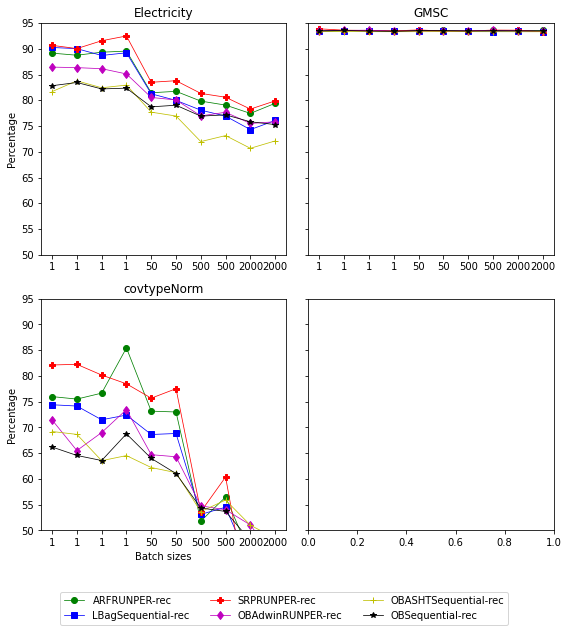

In [195]:
#by default, chart is generated with markers
gen_chart(df)

,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
104,elecNormNew,ARFRUNPER,100,1,1,455.127014,88.983051,88.90923256649167,88.34951593405765
63,elecNormNew,ARFRUNPER,150,1,1,435.002991,89.368757,89.33677524518085,88.86791357000514
50,elecNormNew,ARFSequential,150,1,1,122.735001,88.491228,88.44227839822503,87.72090600401296
135,elecNormNew,ARFSequential,100,1,1,122.580002,89.063181,89.07558203748621,87.89054295955168
164,elecNormNew,ARFMB,150,50,1,120.169998,80.506329,80.09209693885954,79.44386100488107
14,elecNormNew,ARFMB,100,50,1,120.382004,81.090164,80.86290047891899,80.6031940975263
132,elecNormNew,ARFMB,150,500,1,121.699997,78.573333,77.98955128940739,77.43984242169937
66,elecNormNew,ARFMB,100,500,1,123.119003,80.208333,79.96576496674057,79.76181751268132
25,elecNormNew,ARFMB,100,2000,1,120.761002,80.420000,80.87842692311582,79.509282282529
145,elecNormNew,ARFMB,150,2000,1,122.999001,77.533333,79.09100591085787,74.91789819376027


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
82,elecNormNew,LBagSequential,100,1,1,122.038002,90.151307,89.94456751081765,89.46964024723431
100,elecNormNew,LBagSequential,150,1,1,122.181999,90.387931,89.98317050248072,89.85871740679987
8,elecNormNew,LBagRUNPER,150,1,1,451.273987,88.581889,88.54843278467261,87.96360392690396
176,elecNormNew,LBagRUNPER,100,1,1,348.993011,89.214778,89.24611870594656,88.61274566216002
172,elecNormNew,LBagMB,150,50,1,120.027000,82.050179,81.84044510462944,81.88019525439863
10,elecNormNew,LBagMB,100,50,1,120.109001,82.187192,82.09406189601326,81.60174289424883
120,elecNormNew,LBagMB,150,500,1,120.783997,79.075862,78.85740605751418,78.70042637767246
76,elecNormNew,LBagMB,100,500,1,121.413002,78.204255,78.24616718613,76.885462916483
155,elecNormNew,LBagMB,100,2000,1,120.597000,76.330000,76.46003473133243,74.98311013300811
28,elecNormNew,LBagMB,150,2000,1,134.087997,76.457143,76.4033766600589,75.8593356248222


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
59,elecNormNew,SRPRUNPER,150,1,1,473.174988,91.564496,91.52533854010187,91.365766246465
123,elecNormNew,SRPRUNPER,100,1,1,510.617004,90.896309,90.93796649982437,90.44106306440966
30,elecNormNew,SRPSequential,100,1,1,122.327003,92.541254,92.55348854483371,91.92967111210706
144,elecNormNew,SRPSequential,150,1,1,122.367996,92.201835,92.13700915355898,91.40647173820203
149,elecNormNew,SRPMB,150,50,1,120.225998,82.660550,82.30012327443555,80.84591888681487
32,elecNormNew,SRPMB,100,50,1,121.195999,82.910345,82.85460992907801,81.19596584595821
173,elecNormNew,SRPMB,100,500,1,122.802002,79.914286,79.70699701660362,77.93905363084752
38,elecNormNew,SRPMB,150,500,1,123.864998,79.660000,78.79307941520116,77.67786417006184
71,elecNormNew,SRPMB,150,2000,1,130.455994,75.850000,75.83731510482157,72.49335083398717
108,elecNormNew,SRPMB,100,2000,1,127.292000,77.850000,79.86817639325821,75.08141762452108


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
140,elecNormNew,OBAdwinRUNPER,150,1,1,274.027008,86.544598,86.61509650352401,85.53217524697403
31,elecNormNew,OBAdwinRUNPER,100,1,1,220.660004,86.334746,86.395557363363,85.52075406379454
19,elecNormNew,OBAdwinSequential,150,1,1,121.014999,88.276798,88.15540650354016,88.12622513014546
153,elecNormNew,OBAdwinSequential,100,1,1,121.487999,87.881706,87.85543321124472,87.36527868644946
177,elecNormNew,OBAdwinMB,150,50,1,120.128998,80.627628,80.57001706135041,79.45196706997025
6,elecNormNew,OBAdwinMB,100,50,1,107.221001,80.511246,80.45370284439521,79.36873421375282
168,elecNormNew,OBAdwinMB,150,500,1,120.483002,76.811594,76.45583073399477,75.53817993592958
35,elecNormNew,OBAdwinMB,100,500,1,99.168999,77.769347,77.36064817991152,76.8407370806708
166,elecNormNew,OBAdwinMB,150,2000,1,126.170998,76.056250,75.92870907580021,74.50436682727556
1,elecNormNew,OBAdwinMB,100,2000,1,105.648003,75.561045,75.0801749980707,74.6234942515489


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
87,elecNormNew,OBASHTSequential,100,1,1,121.185997,86.123853,86.38262396208492,85.2728954154199
98,elecNormNew,OBASHTSequential,150,1,1,121.486000,87.587549,87.61058796552351,87.16141553855635
115,elecNormNew,OBASHTRUNPER,150,1,1,267.665985,82.450662,83.04970217479179,80.8125019351002
57,elecNormNew,OBASHTRUNPER,100,1,1,202.190002,82.944915,83.49591050577084,81.52503950944248
91,elecNormNew,OBASHTMB,100,50,1,105.140999,77.670010,77.96630475138097,75.96145254509598
85,elecNormNew,OBASHTMB,150,50,1,120.105003,77.315625,77.43011658553594,75.59862494614167
83,elecNormNew,OBASHTMB,150,500,1,120.251999,71.616438,71.24829958535005,69.27247513043757
122,elecNormNew,OBASHTMB,100,500,1,92.546997,73.071945,72.88374395477621,71.25302135184324
4,elecNormNew,OBASHTMB,150,2000,1,123.941002,69.885294,69.05207223712155,68.50111604587124
165,elecNormNew,OBASHTMB,100,2000,1,98.002998,72.056243,71.6740993949546,70.43855147279979


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
51,elecNormNew,OBSequential,100,1,1,121.399002,84.957497,85.29648528299352,83.80274074947897
134,elecNormNew,OBSequential,150,1,1,121.500000,86.420999,86.57478408761348,85.76276559520764
17,elecNormNew,OBRUNPER,150,1,1,234.718994,82.034451,81.6521021535812,81.53911830190343
157,elecNormNew,OBRUNPER,100,1,1,171.664001,82.353460,81.99024862300475,81.8065788947085
137,elecNormNew,OBMB,150,50,1,120.021004,78.464596,78.00004663246183,77.52336774207099
42,elecNormNew,OBMB,100,50,1,90.193001,78.913879,78.5149506439945,78.10653515787142
58,elecNormNew,OBMB,150,500,1,120.627998,76.600000,76.07419176389831,75.82453892610408
97,elecNormNew,OBMB,100,500,1,85.042000,77.068642,76.5769289426018,76.26486528267745
62,elecNormNew,OBMB,100,2000,1,90.180000,75.766531,75.34632522462432,74.71143785017617
131,elecNormNew,OBMB,150,2000,1,122.167000,75.083333,74.49227448258831,73.6829558745886


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
101,GMSC,ARFSequential,150,1,1,122.101997,93.752182,63.68577941434332,51.12214312376828
92,GMSC,ARFRUNPER,100,1,1,301.812988,93.531736,75.32120418099628,52.755456439597324
84,GMSC,ARFSequential,100,1,1,122.018997,93.551402,65.4629241726016,51.05984497491634
77,GMSC,ARFRUNPER,150,1,1,297.394989,93.522815,73.8467349832276,52.09182566370092
146,GMSC,ARFMB,150,50,1,120.399002,93.460993,69.55176542930191,51.24935777389522
26,GMSC,ARFMB,100,50,1,120.430000,93.542169,69.83273248353571,51.726373927430316
163,GMSC,ARFMB,100,500,1,122.434998,93.618605,73.1909632092235,51.7375547788508
27,GMSC,ARFMB,150,500,1,120.886002,93.444444,73.2696067496818,51.425122791678454
105,GMSC,ARFMB,100,2000,1,125.393997,93.561111,74.40431120414985,51.978781446950364
75,GMSC,ARFMB,150,2000,1,131.248993,93.316667,70.48494983277591,51.09375000000001


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
90,GMSC,LBagSequential,150,1,1,121.572998,93.611511,68.69249567938313,53.04169864415452
79,GMSC,LBagSequential,100,1,1,121.843002,93.371648,66.62028479148469,51.98337571419221
147,GMSC,LBagRUNPER,100,1,1,399.152008,93.391275,74.2662207923234,53.069951191115884
39,GMSC,LBagRUNPER,150,1,1,397.903015,93.400335,72.90419790904188,52.48044139171433
5,GMSC,LBagMB,150,50,1,120.021004,93.546448,70.83083286511818,52.163242662166475
178,GMSC,LBagMB,100,50,1,120.053001,93.489982,72.98169411635746,52.476681963204705
169,GMSC,LBagMB,150,500,1,122.664001,93.516667,71.17590707699676,52.03035101512958
33,GMSC,LBagMB,100,500,1,121.681000,93.475000,72.81318838514902,52.472514007747364
52,GMSC,LBagMB,150,2000,1,132.319000,93.443750,69.3648929802053,51.40514361517431
130,GMSC,LBagMB,100,2000,1,123.459999,93.445833,72.43350785340314,51.89444186884611


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
99,GMSC,SRPSequential,150,1,1,122.019997,94.393939,78.48572296476306,51.28871336520474
81,GMSC,SRPSequential,100,1,1,122.082001,93.883090,67.84044928142877,50.7813114636395
9,GMSC,SRPRUNPER,150,1,1,311.390015,93.600509,72.64818786123008,50.74346359956618
175,GMSC,SRPRUNPER,100,1,1,323.708008,93.580879,74.9665646666096,51.126601749377556
96,GMSC,SRPMB,100,50,1,120.181000,93.442060,68.98116307504203,50.47901226711099
74,GMSC,SRPMB,150,50,1,120.630997,93.617834,66.0854330051727,50.44760106803711
118,GMSC,SRPMB,150,500,1,123.220001,93.573333,63.48952075824322,50.2704234448459
78,GMSC,SRPMB,100,500,1,123.646004,93.504348,73.10178372505605,50.626596519289535
48,GMSC,SRPMB,100,2000,1,127.490997,93.360000,64.57755142914365,50.33060800726754
124,GMSC,SRPMB,150,2000,1,125.406998,93.350000,51.744574290484145,50.0476490331806


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
94,GMSC,OBAdwinRUNPER,150,1,1,275.135986,93.459426,75.64956247230838,53.08385855805916
72,GMSC,OBAdwinRUNPER,100,1,1,279.377991,93.468073,77.09490059865412,53.2694682424543
152,GMSC,OBAdwinSequential,150,1,1,121.169998,93.625000,74.62584662442649,52.036468408256574
22,GMSC,OBAdwinSequential,100,1,1,121.441002,93.575203,76.01169383416018,52.53901573472133
16,GMSC,OBAdwinMB,150,50,1,120.028999,93.406157,77.54670702431896,52.03817202271256
167,GMSC,OBAdwinMB,100,50,1,120.023003,93.377028,75.84501438452594,50.915363138519034
154,GMSC,OBAdwinMB,150,500,1,120.373001,93.426804,76.31954622219187,52.30542962675556
0,GMSC,OBAdwinMB,100,500,1,120.250000,93.394483,77.91161729286891,51.64522197006103
143,GMSC,OBAdwinMB,100,2000,1,121.896004,93.336364,74.80301630558776,51.51293083201991
20,GMSC,OBAdwinMB,150,2000,1,121.927002,93.371429,75.7009989459563,52.48255710699908


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
138,GMSC,OBASHTSequential,100,1,1,121.025002,93.355104,75.7,51.5
67,GMSC,OBASHTRUNPER,150,1,1,300.631989,93.306173,75.4,51.0
49,GMSC,OBASHTSequential,150,1,1,121.102997,93.443103,75.4,51.3
112,GMSC,OBASHTRUNPER,100,1,1,295.039001,93.325453,75.8,51.8
40,GMSC,OBASHTMB,100,50,1,120.013000,93.324759,75.8,51.2
133,GMSC,OBASHTMB,150,50,1,120.009003,93.341085,75.0,51.3
111,GMSC,OBASHTMB,150,500,1,120.117996,93.357233,75.0,51.0
47,GMSC,OBASHTMB,100,500,1,120.317001,93.355172,75.4,51.9
37,GMSC,OBASHTMB,150,2000,1,122.320000,93.289394,75.8,51.2
161,GMSC,OBASHTMB,100,2000,1,121.591003,93.316327,75.3,51.0


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
89,GMSC,OBRUNPER,150,1,1,249.210007,93.488706,76.04509251218605,53.60154393237251
95,GMSC,OBRUNPER,100,1,1,251.373001,93.443989,75.72044151426417,53.45312158156658
117,GMSC,OBSequential,150,1,1,121.072998,93.632442,74.3958711725451,52.65783460039132
54,GMSC,OBSequential,100,1,1,121.403999,93.513948,75.79602049707812,52.418297628935186
18,GMSC,OBMB,100,50,1,120.039001,93.458385,77.08671241422334,51.89321457544753
160,GMSC,OBMB,150,50,1,120.015999,93.390288,75.48785935276221,51.924919759571495
106,GMSC,OBMB,150,500,1,120.943001,93.396552,75.91424608362583,52.68030609254636
46,GMSC,OBMB,100,500,1,120.037003,93.463584,76.14790792512278,52.52991283209326
13,GMSC,OBMB,100,2000,1,121.292999,93.448718,76.46487610940585,52.42652366837367
179,GMSC,OBMB,150,2000,1,120.214996,93.362000,75.08081511254933,52.112867080849576


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
60,covtypeNorm,ARFSequential,150,1,1,122.114998,69.452736,?,59.06577371698474
113,covtypeNorm,ARFRUNPER,150,1,1,267.980011,76.498278,76.52781974264329,75.37033247256592
126,covtypeNorm,ARFSequential,100,1,1,121.886002,73.487544,78.93344141389179,72.56293526497932
68,covtypeNorm,ARFRUNPER,100,1,1,319.125000,78.634098,78.38859000968813,77.77137714874168
139,covtypeNorm,ARFMB,100,50,1,120.252998,72.834286,72.85468136334688,71.56012801101667
45,covtypeNorm,ARFMB,150,50,1,120.086998,73.693878,74.21209224448974,67.248876493234
80,covtypeNorm,ARFMB,100,500,1,122.641998,56.023529,57.09532138291573,55.08984312371019
116,covtypeNorm,ARFMB,150,500,1,126.222000,58.727273,61.2578083564982,53.994114783574986
107,covtypeNorm,ARFMB,150,2000,1,149.386002,46.200000,49.68728079552632,46.93184010706105
73,covtypeNorm,ARFMB,100,2000,1,133.087997,41.966667,51.079107887007794,42.18472461997914


ValueError: Unable to parse string "?" at position 0

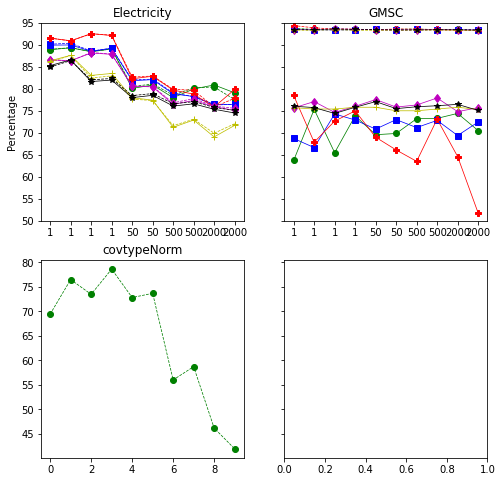

In [79]:
#by default, chart is generated with markers
#the modifier tables outputs the tables used for each serie of the chart
gen_chart(df, tables=True)